In [46]:
import sys
sys.path.append(".")
import importlib
# import datasets.lip_to_word_dataset 
import util.cv_utils
# importlib.reload(datasets.lip_to_word_dataset)
importlib.reload(util.cv_utils)
# from datasets.lip_to_word_dataset import LipReadingWordDataset
from util.cv_utils import collate_fn

import torch
from torch.utils.data import Dataset
from pathlib import Path
from torch.utils.data import DataLoader

# Automatic Mixed Precision
from torch.cuda.amp import autocast, GradScaler


In [47]:
from torch.utils.data import Dataset


class LipReadingWordDataset(Dataset):
    # Implement abstract funcs
    
    # constructor
    # pass in path object of proccessed folder
    def __init__(self, processed_dir):
        self.index_map = []
        self.cache = {} # data optimization as we save loading times for redudant multiple get item calls for data, etc: epochs
        processed_dir = Path(processed_dir)
        for folder in processed_dir.iterdir():
            folder = Path(folder)
            for data_file in folder.glob("*.pth"):            
                data = torch.load(data_file, map_location= 'cpu', weights_only=False)
                num_words = len(data["y_labels"])
                for i in range(num_words):
                    self.index_map.append((data_file, i)) 
                    # load in the indicies and path of each word token, and load actual data in real time for optimization

    def __len__(self):
        # Return total amount of word tokens
        return len(self.index_map)

    def __getitem__(self, idx):
        # Return part of sequence for each word using index map (index being which word in the file)
        data_path, index = self.index_map[idx]
        if data_path not in self.cache:
            self.cache[data_path] = torch.load(data_path, map_location= 'cpu', weights_only= False)
        # load from cache
        data = self.cache[data_path]
        
        # Load data into tensors at runtime
        x_feat, x_coords, x_veloc, x_acc, y_labels = data["x_feat"][index], data["x_coords"][index], data["x_veloc"][index], data["x_acc"][index], data["y_labels"][index]
        return torch.tensor(x_feat, dtype= torch.float32), torch.tensor(x_coords, dtype= torch.float32), torch.tensor(x_veloc, dtype= torch.float32), torch.tensor(x_acc, dtype=torch.float32), torch.tensor(y_labels, dtype= torch.long)
        


In [48]:
# Load data
folder = Path(r"C:\Projects\Lip_Reading\GRID\processed")
# Daniel's Path
# folder = Path(r"C:\Users\User\OneDrive\Documents\Projects\Lip-Reading\GRID\processed")
dataset = LipReadingWordDataset(folder)

train_loader = DataLoader(
    dataset, 
    batch_size=64, #  64
    shuffle=True, 
    collate_fn=collate_fn
    )

In [49]:
# # Define a simple model
# import torch.nn as nn
# import torch.nn.functional as F

# class LipReadingModel(nn.Module):
#     def __init__(self, x_feat, x_coords, x_veloc, hidden_size, num_classes):
#         super(LipReadingModel, self).__init__()

#         input_size = x_feat + x_coords + x_veloc
#         self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        
        
#         # Double the hidden size if LSTM is bidirectional
#         self.dropout = nn.Dropout(p=0.3)  # Dropout rate of 30%
#         self.fc = nn.Linear(hidden_size * 2, num_classes)  

#     def forward(self, x_dim, x_2d1, x_2d2):
#         x = torch.cat([x_dim, x_2d1, x_2d2], dim=2) 
#         _, (h_n, _) = self.lstm(x)  
        
#         # h_n shape: (num_directions, batch, hidden_size)
#         # Concatenate both directions (forward and backward) if bidirectional
#         h_n = torch.cat([h_n[0], h_n[1]], dim=1)
#         h_n = self.dropout(h_n)
        
#         out = self.fc(h_n)      
#         return out

#     def __getitem__(self, idx):
#         x_dim = torch.tensor(self.X_dim[idx], dtype=torch.float32)
#         x2d1  = torch.tensor(self.X_2d1[idx], dtype=torch.float32)
#         x2d2  = torch.tensor(self.X_2d2[idx], dtype=torch.float32)
#         label = torch.tensor(self.y[idx], dtype=torch.long)  # labels must be long for CrossEntropyLoss
#         return x_dim, x2d1, x2d2, label

In [50]:
# CNN + RNN model
import torch.nn as nn
import torch.nn.functional as F

class LipReadingModel_CNN_BiLSTM(nn.Module):
    def __init__(self, x_feat, x_coords, x_veloc, x_acc, hidden_size, num_classes):
        super().__init__()

        # Combine all feature dims
        input_size = x_feat + x_coords + x_veloc + x_acc

        # --- CNN frontend ---
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=128, kernel_size=2, padding=1), # Test 2 instead of 3, as 2-d coordinates ...
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Conv1d(in_channels=128, out_channels=256, kernel_size=2, padding=1),  # Test 2 instead of 3, as 2-d coordinates ...
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # --- BiLSTM backend --- (RNN)
        self.lstm = nn.LSTM(
            input_size=256,        # after CNN
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.3
        )

        # --- Fully connected classifier ---
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x_1, x_2, x_3, x_4):
        # Concatenate along feature dimension
        x = torch.cat([x_1, x_2, x_3, x_4], dim=2)  # shape: [B, T, F]

        # CNN expects (B, F, T)
        x = x.transpose(1, 2)  # -> [B, F, T]
        x = self.cnn(x)        # -> [B, 256, T]
        x = x.transpose(1, 2)  # -> [B, T, 256]

        # LSTM
        _, (h_n, _) = self.lstm(x)  
        h_n = torch.cat([h_n[-2], h_n[-1]], dim=1)  # last layer's forward & backward

        # Classifier
        out = self.fc(h_n)
        return out


In [51]:
model = LipReadingModel_CNN_BiLSTM(
    x_feat = 8,
    x_coords = 18,
    x_veloc = 18,
    x_acc = 18,
    hidden_size = 256, # 256
    num_classes = 55
)

In [52]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)


# TODO AJUST lr to increase loss rate of change precision

In [58]:
# prefer gpu "cuda"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = GradScaler()
model = model.to(device)

for epoch in range(50):
    model.train()
    total_loss = 0.0
    for x1, x2, x3, x4, y in train_loader:

        # Move data to device
        x1 = x1.to(device)
        x2 = x2.to(device)
        x3 = x3.to(device)
        x4 = x4.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        with autocast():
            outputs = model(x1, x2, x3, x4)
            loss = criterion(outputs, y)

        # Backpropagation
        scaler.scale(loss).backward()
        
        # Unscale before clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Step with scaled
        scaler.step(optimizer)
        scaler.update()
    
        total_loss += loss.item()
        
    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")


C:\Users\ryanv\AppData\Local\Temp\ipykernel_7716\2960115066.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\ryanv\AppData\Local\Temp\ipykernel_7716\2960115066.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Loss = 0.3636
Epoch 2: Loss = 0.3847
Epoch 3: Loss = 0.3236
Epoch 4: Loss = 0.2380
Epoch 5: Loss = 0.2619
Epoch 6: Loss = 0.0726
Epoch 7: Loss = 0.2990
Epoch 8: Loss = 0.5682
Epoch 9: Loss = 0.3683
Epoch 10: Loss = 0.1746
Epoch 11: Loss = 0.1964
Epoch 12: Loss = 0.2329
Epoch 13: Loss = 0.6725
Epoch 14: Loss = 0.1361
Epoch 15: Loss = 0.3036
Epoch 16: Loss = 0.3123
Epoch 17: Loss = 0.1324
Epoch 18: Loss = 0.2318
Epoch 19: Loss = 0.0671
Epoch 20: Loss = 0.4306
Epoch 21: Loss = 0.1682
Epoch 22: Loss = 0.4641
Epoch 23: Loss = 0.1910
Epoch 24: Loss = 0.1531
Epoch 25: Loss = 0.1139
Epoch 26: Loss = 0.1072
Epoch 27: Loss = 0.1430
Epoch 28: Loss = 0.5605
Epoch 29: Loss = 0.4331
Epoch 30: Loss = 0.1618
Epoch 31: Loss = 0.3080
Epoch 32: Loss = 0.2911
Epoch 33: Loss = 0.3276
Epoch 34: Loss = 0.2249
Epoch 35: Loss = 0.1560
Epoch 36: Loss = 0.1181
Epoch 37: Loss = 0.1017
Epoch 38: Loss = 0.0759
Epoch 39: Loss = 0.1954
Epoch 40: Loss = 0.1540
Epoch 41: Loss = 0.4596
Epoch 42: Loss = 0.0871
E

In [56]:
vocab = {
    "<pad>": 0,
    "<sos>": 1,
    "<eos>": 2,
    "sp": 3,
    "bin": 4,
    "lay": 5,
    "place": 6,
    "set": 7,
    "blue": 8,
    "green": 9,
    "red": 10,
    "white": 11,
    "at": 12,
    "by": 13,
    "in": 14,
    "with": 15,
    "zero": 16,
    "one": 17,
    "two": 18,
    "three": 19,
    "four": 20,
    "five": 21,
    "six": 22,
    "seven": 23,
    "eight": 24,
    "nine": 25,
    "again": 26,
    "now": 27,
    "please": 28,
    "soon": 29,
    "a": 30,
    "b": 31,
    "c": 32,
    "d": 33,
    "e": 34,
    "f": 35,
    "g": 36,
    "h": 37,
    "i": 38,
    "j": 39,
    "k": 40,
    "l": 41,
    "m": 42,
    "n": 43,
    "o": 44,
    "p": 45,
    "q": 46,
    "r": 47,
    "s": 48,
    "t": 49,
    "u": 50,
    "v": 51,
    "x": 52,
    "y": 53,
    "z": 54
}
inverse_vocab = {v: k for k, v in vocab.items()}

In [ ]:
# Adding Metrics and Evaluation
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x1, x2, x3, x4, y in train_loader:
        x1 = x1.to(device)
        x2 = x2.to(device)
        x3 = x3.to(device)
        x4 = x4.to(device)
        y = y.to(device)

        outputs = model(x1, x2, x3, x4)
        predicted = outputs.argmax(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# Compute metrics
acc = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Final Training Accuracy: {acc:.2%}")

labels_list = list(range(len(vocab)))
target_names = [inverse_vocab[i] for i in labels_list]

# Optional detailed report

# print(classification_report(all_labels, all_preds, labels=labels_list, target_names=target_names))
report = classification_report(all_labels, all_preds, labels=labels_list, target_names=target_names, output_dict=True)
df = pd.DataFrame(report).transpose()  # Transpose to have labels as rows
df.to_csv("classification_report_v2.csv", index=True)

# Optional confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels = labels_list)
# print("Confusion Matrix:\n", cm)
cm_df = pd.DataFrame(
    cm,
    index=[inverse_vocab[i] for i in labels_list],      # True labels as row names
    columns=[inverse_vocab[i] for i in labels_list]     # Predicted labels as column names
)
cm_df.to_csv("confusion_matrix_v2.csv")

# Daniel's Note:
# I've noticed that the model is not performing well, getting words mixed up 
# ex. "one" and "blue" probably due to lack of teeth and tongue data.
# Looking at the confusion_matrix.csv can help identify which words are being confused for which.



TypeError: LipReadingModel_CNN_BiLSTM.forward() missing 1 required positional argument: 'x_4'

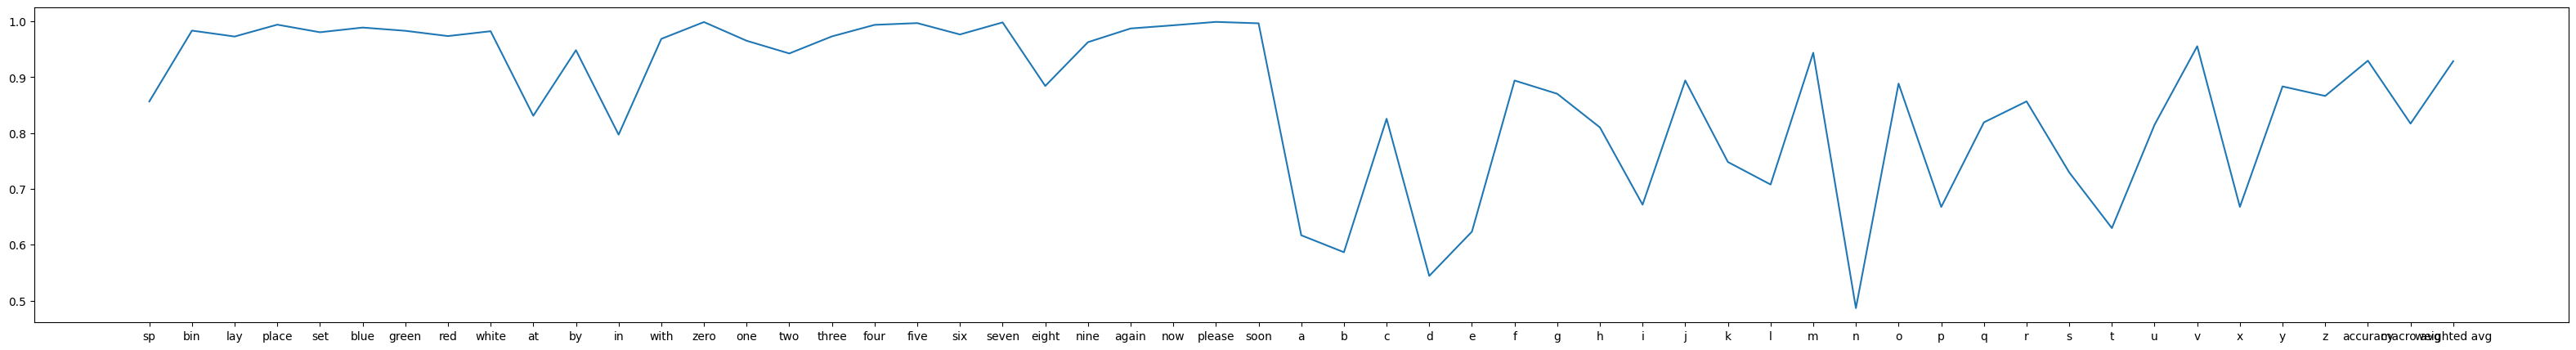

In [ ]:
import numpy
import matplotlib.pyplot as plt
f1_score = df['f1-score'][3:]
plt.figure(figsize=(40, 5))
plt.plot(f1_score)
